# SD201 Project 

## Dataset (from a Kaggle competition) : Instacart Market Basket Analysis

Link : https://www.kaggle.com/c/instacart-market-basket-analysis/data

Blog post about the competition : https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2

Key points from the dataset:

- 3M grocery store orders
- 200,000+ Instacart users
- 4 to 100 orders for each user, timestamped

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 10/12/2021"

## Introduction

In this project, we seek to predict the next basket items for a client given a history of past orders. This is a multi-label classification problem.

Auxiliary questions :

- relation between item categories and associations (Apriori algorithm) ?
- clustering of aisles/departments ?

In [137]:
pip install pyECLAT

Note: you may need to restart the kernel to use updated packages.


In [138]:
'''Python librairies''' 

# Utility librairies
import pandas as pd
import scipy.stats as s
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing librairies
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

# Classifiers that support multi-label output
from sklearn.ensemble import RandomForestClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import f1_score

# Pretty charts
import seaborn as sns
sns.set_theme(style="ticks")

In [4]:
aisles = pd.read_csv('./instacart/aisles.csv')
departments = pd.read_csv('./instacart/departments.csv')
op_prior = pd.read_csv('./instacart/order_products__prior.csv')
op_train = pd.read_csv('./instacart/order_products__train.csv')
orders = pd.read_csv('./instacart/orders.csv')
products = pd.read_csv('./instacart/products.csv')
sample_submission = pd.read_csv('./instacart/sample_submission.csv')

## Exploratory data analysis 

### Description of the dataset 

`aisles` : the different aisles of the Instacart platform.

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


`departments` : departments for the products.

In [4]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


`op_prior` and `op_train` are the orders that shall be used as training and testing sets respectively. In the competition, we make predictions for the `test` set, but we can check that our model works with the `train` set.

In those DataFrames, `add_to_cart_order` indicates if for a given order, the product was added first, second, etc.

`reordered` indicates if the product has already been ordered by the user making the order (1 if `True`, else 0).

`op_prior` contains all past orders with the correponding products for all clients.

In [5]:
op_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


`orders` contains all the orders of the dataset, including :

- which user ordered (`user_id`)
- which set the row belongs to : prior, train or test (`eval_set`)
- information about the number of orders they have already completed (`order_number`)
- on which day of the week they ordered (`order_dow`) and hour of the day (`order_hour_of_day`)
- and how many days have elapsed since the last order (`days_since_prior_order`) 

In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


`products` contains the name of each product, as well as which aisle and department it belongs to.

In [7]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


`sample_submission` gives an example of how to format the response (for the competition).

###### From the Kaggle competition :

For each orderid in the test set, you should predict a space-delimited list of productids for that order. If you wish to predict an empty order, you should submit an explicit 'None' value. You may combine 'None' with product_ids. The spelling of 'None' is case sensitive in the scoring metric. The file should have a header and look like the following:

In [8]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


### Data exploration

Let's take a closer look at our data.

First let's examine the `orders` file.

The code for charts is given once as example and then hidden to save space.

Since the data is already split into training and testing data, we can first wonder what is the fraction of train, test, and prior data?

In [9]:
counts = orders.eval_set.value_counts()
print(counts)
total = len(orders)
print('Train fraction:', counts[1]/total)
print('Test fraction:',  counts[2]/total)
print('Prior fraction:', counts[0]/total)

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64
Train fraction: 0.03835305954284067
Test fraction: 0.021922882315336987
Prior fraction: 0.9397240581418224


Here we train our model using the prior data, and make predictions for the test data.

On which day of the week do people usually order on Instacart?

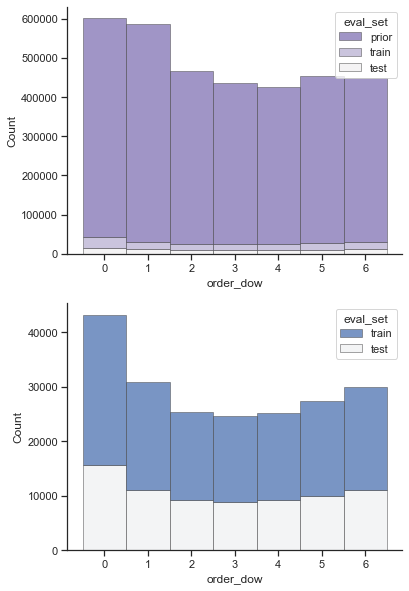

In [10]:
fig, axes = plt.subplots(2,1,figsize=(6, 10))
sns.despine(fig)

unique_dow = len(orders.order_dow.unique())+1

# Counting order_dow for all prior, train, and test sets
sns.histplot(
    orders,
    x="order_dow",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_dow)-.5,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[0]
)

# Counting order_dow for train and test sets only
sns.histplot(
    orders[orders.eval_set != "prior"],
    x="order_dow",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_dow)-.5,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[1]
)

plt.show()

People seem to order more on days 0 and 1, which we may assume correspond to weekends (the dataset does not give us this data).

When do people usually place their order in the day?

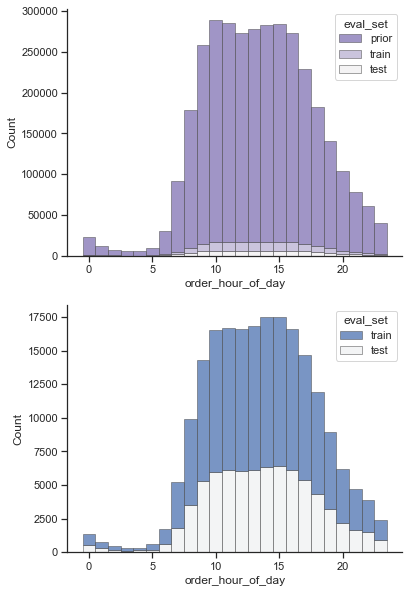

In [11]:
fig, axes = plt.subplots(2,1,figsize=(6, 10))
sns.despine(fig)

unique_hours = len(orders.order_hour_of_day.unique())+1

# Counting order_hour_of_day for all prior, train, and test sets
sns.histplot(
    orders,
    x="order_hour_of_day",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_hours)-.5,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[0]
)

# Counting order_hour_of_day for train and test sets only
sns.histplot(
    orders[orders.eval_set != "prior"],
    x="order_hour_of_day",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_hours)-.5,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[1]
)

axes[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axes[1].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()

Most people seem to order between 10 am and 4 pm. We notice that the distribution seems to be gaussian, so we could try standardizing this columns before training our models.

At which frequency do people order on Instacart?

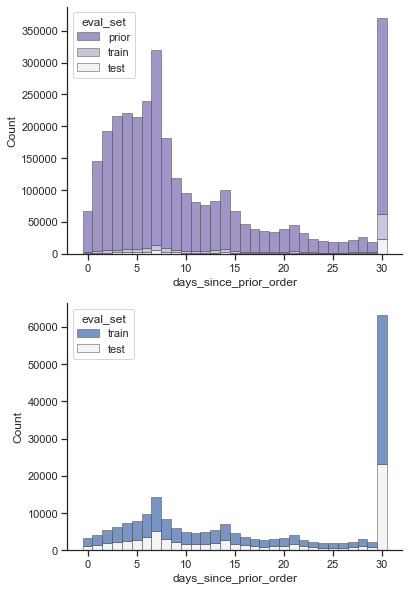

In [12]:
fig, axes = plt.subplots(2,1,figsize=(6, 10))
sns.despine(fig)

unique_dspo = len(orders.days_since_prior_order.dropna().unique()) + 1

# Counting days_since_prior_order for all prior, train, and test sets
sns.histplot(
    orders,
    x="days_since_prior_order",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_dspo)-.5,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[0]
)

# Counting days_since_prior_order for train and test sets only
sns.histplot(
    orders[orders.eval_set != "prior"],
    x="days_since_prior_order",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_dspo)-.5,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[1]
)

axes[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axes[1].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()

We see a surge at exactly one week. The 30 days value seem to encompass all values of 30 days or more.

How many reorders are there for each client in the dataset?

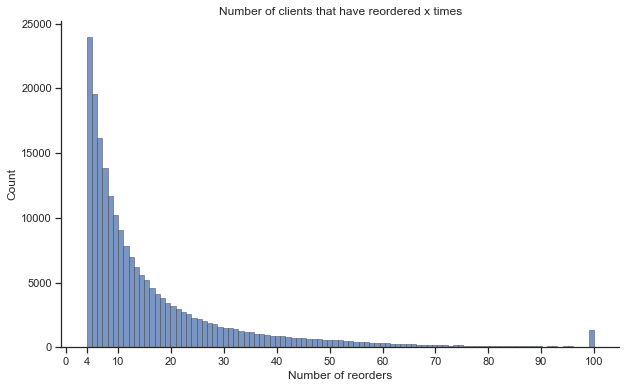

In [69]:
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)

unique_reorders = len(orders.groupby('user_id').order_id.count().unique())

# Counting the number of reorders for all the clients in the dataset
sns.histplot(
    orders.groupby('user_id').order_id.count(),
    stat="count",
    palette="light:m",
    bins=unique_reorders,
    edgecolor=".3",
    linewidth=.5
).set(title="Number of clients that have reordered x times")
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([0,4,10,20,30,40,50,60,70,80,90,100])
ax.set(xlabel="Number of reorders",
       ylabel="Count")
plt.show()

As expected, we have between 4 and 100 orders for each client (in the complete dataset).

We can check the same thing for the training and testing sets separately.

In [14]:
print(orders[orders.eval_set == 'train'].duplicated(subset='user_id').unique())
print(orders[orders.eval_set == 'test'].duplicated(subset='user_id').unique())

[False]
[False]


In the `train` and `test` sets, we only have 1 order per client.

In [12]:
# Number of different items ordered by clients

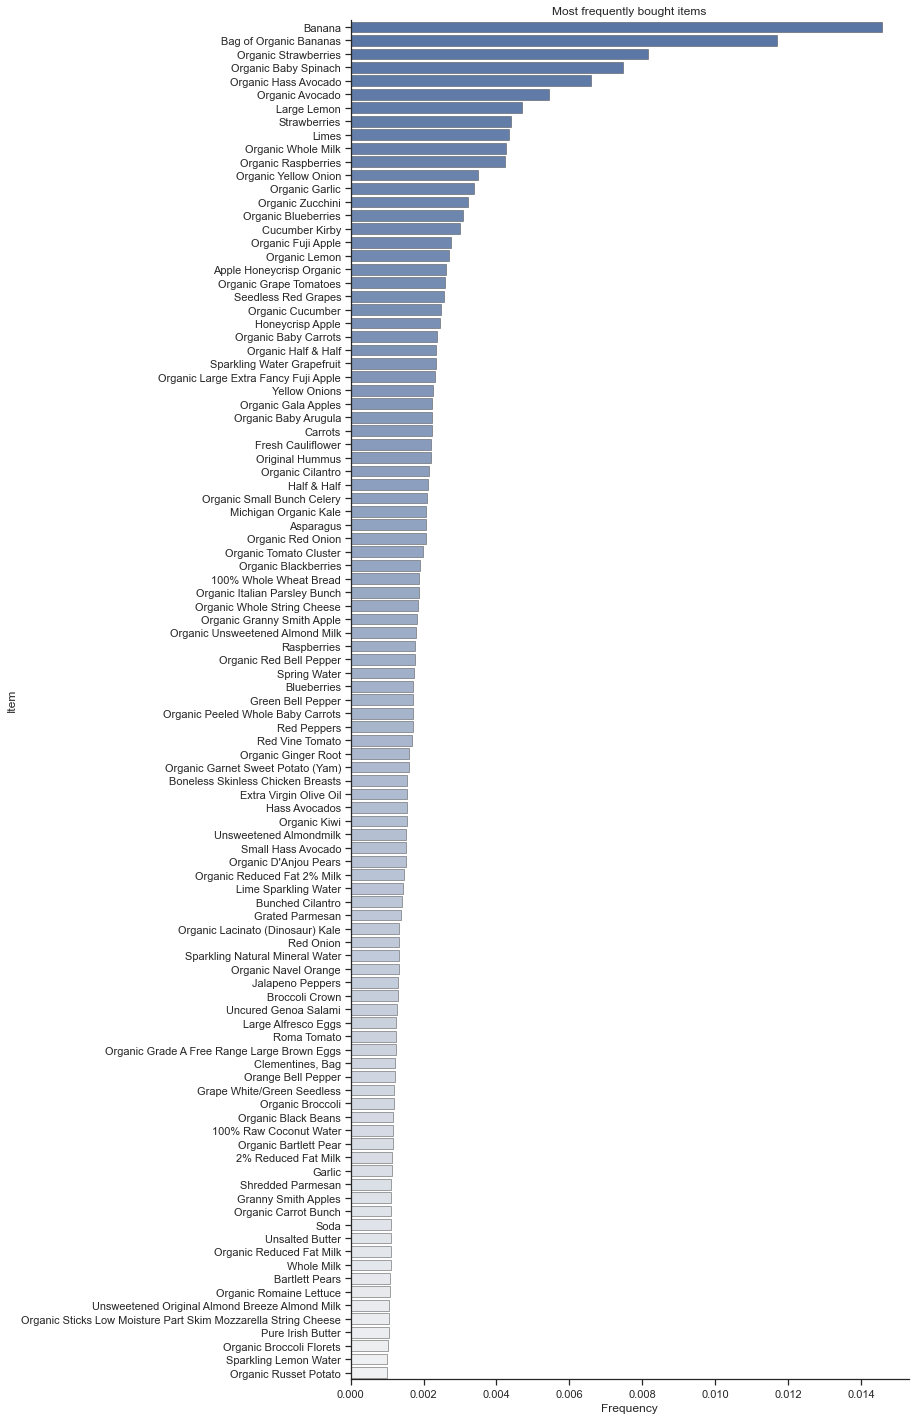

In [136]:
# Item frequency distribution

# Create the DataFrame with the frequency of appearance of ordered items
order_count = len(op_prior)
item_freq = op_prior.product_id.value_counts()
item_freq = pd.DataFrame(item_freq.reset_index())
item_freq.rename(columns={'product_id':'n_occ', 'index':'product_id'}, inplace= True)
item_freq['frequency'] = item_freq['n_occ']/order_count
item_freq = item_freq.merge(products, on='product_id')

# Plot
f, ax = plt.subplots(figsize=(10, 25))
sns.despine(f)

unique_reorders = len(orders.groupby('user_id').order_id.count().unique())

sns.barplot(
    x='frequency',
    y='product_name',
    data=item_freq[item_freq.frequency>10e-4], # Only plot the 101 most frequently bought items
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5
).set(title="Most frequently bought items")
ax.set(xlabel="Frequency",
       ylabel="Item")
plt.show()

Fruits and vegetable, including organic fruits and vegetables, are the most popular among Instacart users.

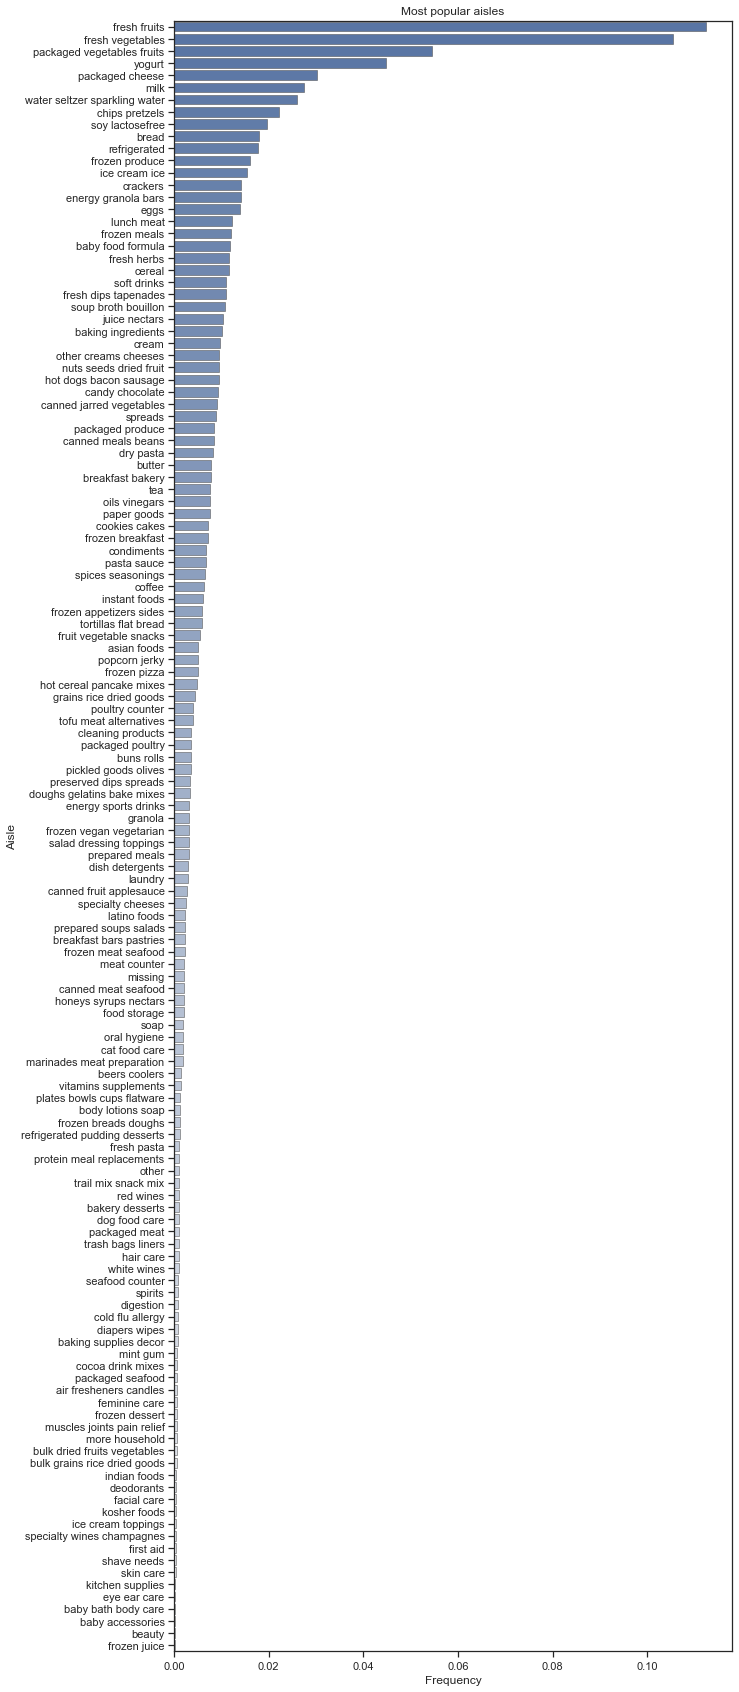

In [129]:
# Most popular aisles

aisle_freq = item_freq.groupby('aisle_id').n_occ.sum().sort_values(ascending=False)
aisle_freq = pd.DataFrame(aisle_freq.reset_index())
aisle_freq['frequency'] = aisle_freq['n_occ']/order_count
aisle_freq = aisle_freq.merge(aisles, on='aisle_id')

f, ax = plt.subplots(figsize=(10, 30))

unique_reorders = len(orders.groupby('user_id').order_id.count().unique())

sns.barplot(
    x='frequency',
    y='aisle',
    data=aisle_freq,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5
).set(title="Most popular aisles")
ax.set(xlabel="Frequency",
       ylabel="Aisle")
plt.show()

We see that fresh fruits and vegetables are the most popular aisles on Instacart, which is logical since they contain products that are more frequently ordered than other shelf stable products.

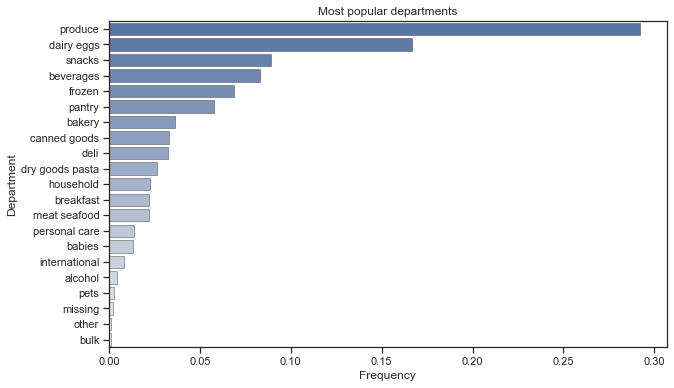

In [127]:
# Most popular departments

dep_freq = item_freq.groupby('department_id').n_occ.sum().sort_values(ascending=False)
dep_freq = pd.DataFrame(dep_freq.reset_index())
dep_freq['frequency'] = dep_freq['n_occ']/order_count
dep_freq = dep_freq.merge(departments, on='department_id')

f, ax = plt.subplots(figsize=(10, 6))

unique_reorders = len(orders.groupby('user_id').order_id.count().unique())

sns.barplot(
    x='frequency',
    y='department',
    data=dep_freq,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5
).set(title="Most popular departments")
ax.set(xlabel="Frequency",
       ylabel="Department")
plt.show()

We see that food items (fresh or shelf stable) are the most popular departments on Instacart.

### Data cleaning

We can check that the only problem we have with missing values are in the `orders` file, in which a certain number of `days_since_prior_order` entries are missing.

In [5]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [6]:
np.sort(orders.days_since_prior_order.unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., nan])

We need to figure out what to do with `nan` entries in days_since_prior order.

What exactly are those entries? Counting the number of unique clients, we get that there are exactly as many null entries as there are clients.

In [7]:
len(orders.user_id.unique())

206209

Intuitively, we can guess that those null entries correspond to the first order for each of those clients. We can check this by counting the number of null entries for each client.

In [8]:
orders.days_since_prior_order.isnull().groupby(orders['user_id']).sum().unique()

array([1], dtype=int64)

We indeed get exactly one `nan` entry for each client, which confirms our assumption that those entries correpond to the first order for each client.

What could be a good strategy for dealing with those entries?

We could try either to drop them entirely from our dataset, or to backfill them with some value (be it the average elasped time for all orders, or the average elapsed time between two orders for the given client).

Since most clients only have 4 orders, dropping the first order would mean dropping 25% of the data for this client. For this reason, we choose not to drop any row.

We can compare both methods using pipelines.

In [9]:
# Imputing the average over all orders
avg_imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Imputing the average for a given client in a pipeline necessitates writing a custom imputer.
# This is optional and will be done if there is enough time.

We can now convert the dtype of `days_since_prior_order`.

#### Formatting the data 

We cannot exploit our relational data directly: we need to perform merges using the keys in the data, and then perform an aggregation over the ordered products to get arrays for each cart.

Moreover, we do not need to perform a merge over the `products` DataFrame because the data there is redundant and already fully determined by the `product_id`. Therefore performing a merge there would induce data-leakage when training our model.

In [10]:
def arrange_data(op_data):
    '''
    Format the data so that to each order corresponds an array of product_id (the cart),
    and an array indicating whether an item was reordered or not.
    op_data can be either op_train or op_prior.
    '''
    data = orders.merge(op_data, on='order_id')
    
    # Aggregate the carts into arrays
    groupby_cols = ['order_id',
                'user_id',
                'eval_set',
                'order_number',
                'order_dow',
                'order_hour_of_day',
                'days_since_prior_order']
    
    data = data.groupby(groupby_cols).aggregate(lambda x: list(x))
    
    # Rename the product_id column to 'cart'
    train_data.rename(columns = {'product_id':'cart'}, inplace = True)
    
    # Reset the index that was changed by the aggregation
    data = data.reset_index()
    
    return data

In [11]:
# Create the DataFrame with aggregated carts for each order
train_data = arrange_data(op_prior)

# Since `add_to_cart_order` corresponds to the order of the products in `product_id`, it is redundant.
train_data.drop(columns='add_to_cart_order', inplace=True)

In [2]:
# Change the data types for all columns to optimize memory use.

# We compare the memory saved by changing the data types.
before_m = train_data.memory_usage().sum()

# We must signal to Python that these columns represent categorical data 
# so that the models work correctly.
train_data['order_id'] = train_data['order_id'].astype('category')
train_data['user_id'] = train_data['user_id'].astype('category')
train_data['eval_set'] = train_data['eval_set'].astype('category')
train_data['order_number'] = train_data['order_number'].astype('category')

train_data['order_dow'] = train_data['order_dow'].astype('uint8')
train_data['order_hour_of_day'] = train_data['order_hour_of_day'].astype('uint8')
train_data['days_since_prior_order'] = train_data['days_since_prior_order'].astype('float16')
after_m = train_data.memory_usage().sum()

# How much memory have we saved ?
(before_m-after_m)/before_m

NameError: name 'train_data' is not defined

In [46]:
test = mlb.transform(train_data['cart'])

TypeError: 'int' object is not iterable

In [47]:
y = test

In [ ]:
# # Isolate the first item in each cart
# first_product = [train_data.product_id[i][0] for i in range(len(train_data))]
# train_data['product1'] = first_product

# train_data = orders.merge(op_train, on='order_id')
# train1 = train_data[train_data.add_to_cart_order == 1]
# train_data.dtypes

### Feature engineering 

#### Creating new features 

In [49]:
# Number of items in the cart
train_data['n_products'] = train_data.cart.apply(lambda x: len(x))
train_data['n_products'] = train_data['n_products'].astype('uint8')

In [51]:
# Number of reordered items in the cart
train_data['n_reord'] = train_data.reordered.apply(lambda x: np.count_nonzero(x))
train_data['n_reord'] = train_data['n_reord'].astype('uint8')

In [ ]:
# Average number of days elapsed between orders for a given client
train_data.groupby('user_id').days_since_prior_order.mean()

In [ ]:
train_data.groupby('user_id').days_since_prior_order.mean()

In [ ]:
train_data[train_data.user_id == 24523]

Ideas:

- number of reordered products
- fraction of reordered products
- probability of a product to be reordered
- convert date

### Data mining 

#### Association rule mining 

#### Multi-label classification based on user-id and time

Question: how should we train the model? A first approach would be to try to train a general predictor for all clients, meaning that the predictor is not "personalized" to the client.

To effectively apply algorithms for a multi-label problem, we either need to transform our carts into a sparse matrix using `sklearn.preprocessing.MultiLabelBinarizer`, or to use `sklearn.multioutput.MultiOutputClassifier` to extend a single variable classifier into a multi-label one.

In [ ]:
features = ['user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'n_products', 'n_reord']

train_X = train_data[features]
train_y = 
# y = train_data['product_id']

# Convert the carts into sparse matrix format
mlb = MultiLabelBinarizer(sparse_output=True)
mlb.fit([list(products.product_id)])

train_X, val_X, train_y, val_y = train_test_split(X, y)

clf = OneVsRestClassifier(SVC()).fit(train_X, train_y)

# model = XGBClassifier()
# model.fit(train_X, np.array(train_y))

In [ ]:
y_pred = model.predict(val_X)
print("F1-Score: " + str(f1_score(val_y,np.round(y_pred))), average='micro')

In [ ]:
op_prior.memory_usage()